# 1. Introduction
In hope of ending the global COVID-19 pandemic, multiple vaccines have been rapidly developed around the world. However, vaccine hesitancy due to safety concerns is hindering its usage. Phase 2 and 3 clinical trials showed promising results regarding both efficacy and adverse effects, also in people with underlying medical conditions [Choi, 2021].  
In this project, the effect of two different vaccines, namely Pfizer-BioNTech and Oxford/AstraZeneca, on people in the UK with different underlying diseases will be analysed, aiming to shed more light on their safety. Specifically, the following questions will be answered: 
* How common are adverse events? Are they more common in people with (specific categories of) underlying medical conditions? Medical events with an ICD10 code after the second vaccine will be considered and compared to unvaccinated people in a similar time frame. 
* Is the mortality the same in vaccinated vs. non-vaccinated people? Is it the same when comparing vaccinated and non-vaccinated people with the same underlying diseases?

Both analyses start more generally with the full population. The population to be analysed is then reduced to only people with underlying medical conditions and then to specific categories of underlying diseases according to ICD10.  

# 2. Methods

## Import packages and data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from scipy import stats
import random
random.seed(13)

#### Import data

In [2]:
# need to import this file in slightly different way because of different delimiters
clinical = pd.read_csv('data/covid19_clinical_sample.txt',sep='\t|,', engine = 'python')

In [3]:
GPic10 = pd.read_csv('data/GP_ic10_lookup.csv') 

In [4]:
mortality = pd.read_csv('data/patients_data_death_sample.csv')

In [5]:
mortality_coding = pd.read_csv('data/patients_data_death_decoding.csv')

#### Have a look at the data

In [6]:
# delete all of these ouputs 

clinical
# GP dataset from patients in the database
# each line corresponds to one incident with a date (event_dt), including vaccinations
# eid: patient number 
# code_type: ?
# value: measured value of a test or something similar

,Unnamed: 0,eid,event_dt,code_type,code,value
0,0,1000034,25/07/2017,0,XaIyt,0.000000
1,1,1000034,26/06/2018,0,XaF8d,0.000000
2,2,1000034,22/08/2017,0,XaF8d,0.000000
3,3,1000034,04/08/2015,0,XaF8d,0.000000
4,4,1000034,07/06/2018,0,XaIeG,0.000000
...,...,...,...,...,...,...
999995,999995,1033328,23/05/2012,0,42N..,0.330000
999996,999996,1033328,10/07/2013,0,246A.,80.000000
999997,999997,1033328,23/05/2012,0,XaK8y,83.300003
999998,999998,1033328,20/05/1997,0,246A.,80.000000


In [7]:
GPic10
#translates CTV3 codes (read_code) to ICD10 (icd10_code)

,Unnamed: 0,read_code,icd10_code,mapping_status,refine_flag,add_code_flag,element_num,block_num
0,0,123..,Z831,D,C,M,0.0,0.0
1,1,123..,Z830,A,C,M,0.0,0.0
2,2,1231.,Z831,G,C,M,0.0,0.0
3,3,1232.,Z831,G,C,M,0.0,0.0
4,4,1233.,Z831,G,C,M,0.0,0.0
...,...,...,...,...,...,...,...,...
116372,116372,ZVy..,Z769,D,C,C,0.0,0.0
116373,116373,ZVz..,Z769,D,C,C,0.0,0.0
116374,116374,NaN,NaN,NaN,NaN,NaN,NaN,NaN
116375,116375,"Contains information from NHS Digital, licence...",NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
mortality
# contains death dates and other info such as age and cause of death

,Unnamed: 0,eid,31-0.0,34-0.0,52-0.0,53-0.0,21001-0.0,21022-0.0,40000-0.0,40001-0.0,40001-1.0,40007-0.0
0,334517,4345610,1.0,1940.0,2.0,2009-09-17,28.4091,69.0,NaN,NaN,NaN,NaN
1,297000,3970369,1.0,1949.0,12.0,2008-04-18,26.1106,58.0,NaN,NaN,NaN,NaN
2,260822,3608558,1.0,1943.0,2.0,2010-02-26,27.4614,67.0,NaN,NaN,NaN,NaN
3,245361,3453904,0.0,1957.0,8.0,2010-03-19,29.3199,52.0,NaN,NaN,NaN,NaN
4,25616,1256219,1.0,1959.0,7.0,2008-12-20,32.7859,49.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
9995,218679,3187034,0.0,1969.0,4.0,2009-10-19,26.1005,40.0,NaN,NaN,NaN,NaN
9996,282089,3821234,0.0,1962.0,5.0,2010-03-02,28.3801,47.0,NaN,NaN,NaN,NaN
9997,219163,3191883,1.0,1964.0,1.0,2008-09-12,13.9123,44.0,NaN,NaN,NaN,NaN
9998,55963,1559739,0.0,1946.0,10.0,2008-10-08,25.4259,61.0,NaN,NaN,NaN,NaN


In [9]:
mortality_coding
# coding of column names

,Unnamed: 0,description
0,eid,PatientID
1,21022-0.0,AgeRecruit
2,53-0.0,DateRecruit
3,34-0.0,YearBirth
4,52-0.0,MonthBirth
5,40007-0.0,AgeDeath
6,40000-0.0,DateDeath
7,31-0.0,Sex
8,21001-0.0,BMI
9,40001-0.0,cause of death 1


## Preparing data

### Data Cleaning

In [10]:
# drop unnecessary columns
clinical.drop(columns = ['code_type', 'value'], inplace = True)

In [11]:
# delete 

pd.isnull(clinical).sum()
# no NaN

Unnamed: 0    0
eid           0
event_dt      0
code          0
dtype: int64

In [12]:
# remove duplicate entries 
clinical.drop_duplicates(inplace = True) 
mortality.drop_duplicates (inplace = True)

#### Make 'event_date' in 'clinical' a datetime type

In [13]:
# convert entire event_dt in datetime format
clinical['event_dt'] = pd.to_datetime(clinical['event_dt'])
clinical

,Unnamed: 0,eid,event_dt,code
0,0,1000034,2017-07-25,XaIyt
1,1,1000034,2018-06-26,XaF8d
2,2,1000034,2017-08-22,XaF8d
3,3,1000034,2015-04-08,XaF8d
4,4,1000034,2018-07-06,XaIeG
...,...,...,...,...
999995,999995,1033328,2012-05-23,42N..
999996,999996,1033328,2013-10-07,246A.
999997,999997,1033328,2012-05-23,XaK8y
999998,999998,1033328,1997-05-20,246A.


### Adding column with IC10 categories to clinical dataset for simpler analysis later on

In [14]:
# create a reduced dataframe for merging with the clinical dataframe
GPic10_red =  GPic10[['read_code', 'icd10_code']]
# rename to merge on the ctv3 column with the clinical dataset
GPic10_red = GPic10_red.rename(columns = {'read_code':'code'})

In [15]:
clinical_ic10 = pd.merge(clinical, GPic10_red, how='inner', on='code')
clinical_ic10

,Unnamed: 0,eid,event_dt,code,icd10_code
0,42,1000034,1998-05-13,XE1lT,S832
1,326324,1011402,2003-08-15,XE1lT,S832
2,326338,1011402,2004-11-03,XE1lT,S832
3,326339,1011402,2004-07-16,XE1lT,S832
4,371890,1012829,2015-06-01,XE1lT,S832
...,...,...,...,...,...
188488,996399,1033266,2015-06-23,XaDbE,R568
188489,999941,1033328,2018-11-12,X2060,I839
188490,999941,1033328,2018-11-12,X2060,I83
188491,999941,1033328,2018-11-12,X2060,O220


In [16]:
# remove not considered clinical events in the clinical dataset (e.g. external factors)
# remove O-Z, but leave R as adverse event & Q as underlying disease.

# tuple of categories we do not consider as adverse event or underlying disease:
exclude = ('O','P','S','T','U','V','W','X','Y','Z')

# broadcasting the clinical dataset for all icd codes except those we exclude
clinical_ic10 = clinical_ic10[~clinical_ic10['icd10_code'].str.startswith(exclude)]

# delete
clinical_ic10

,Unnamed: 0,eid,event_dt,code,icd10_code
12,43,1000034,1978-01-01,XE0e7,N419
13,43,1000034,1978-01-01,XE0e7,N41
14,401061,1013867,2003-10-01,XE0e7,N419
15,401061,1013867,2003-10-01,XE0e7,N41
16,49,1000034,2019-01-23,XE1FC,M543
...,...,...,...,...,...
188460,996093,1033266,2016-11-02,XaQv0,R452
188461,996170,1033266,2015-02-25,X75Z0,R568
188488,996399,1033266,2015-06-23,XaDbE,R568
188489,999941,1033328,2018-11-12,X2060,I839


### NEW OPTION of filtering data by vaccination status

In [17]:
# codes for covid vaccinations in the clinical dataset as found in the file 8708.tsv
clinical[clinical['code']=='Y29e7'] # first dose
clinical[clinical['code']=='Y29e8'] # second dose
clinical[clinical['code']=='Y2a0e'] # SARS-2 Coronavirus vaccine
clinical[clinical['code']=='Y210d'] # Severe acute respiratory syndrome coronavirus 2 vaccination (procedure)
clinical[clinical['code']=='Y2eb5'] # COVID-19 Vaccine Novavax (adj) 5mcg/0.5ml dose susp for inj multidose vials (Baxter Oncology GmbH) part 1
clinical[clinical['code']=='Y2eb5'] # COVID-19 Vaccine Novavax (adj) 5mcg/0.5ml dose susp for inj multidose vials (Baxter Oncology GmbH) part 2

,Unnamed: 0,eid,event_dt,code


In [18]:
clinical_vaccines_only = clinical[clinical['code']=='Y29e7'] # first dose

In [19]:
clinical_vaccines_only['issue_dt'] =  clinical_vaccines_only['event_dt']
clinical_vaccines_only

C:\Users\moniz\AppData\Local\Temp/ipykernel_25692/3056486916.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clinical_vaccines_only['issue_dt'] =  clinical_vaccines_only['event_dt']


,Unnamed: 0,eid,event_dt,code,issue_dt
797,797,1000087,2021-02-02,Y29e7,2021-02-02
1981,1981,1000118,2021-01-26,Y29e7,2021-01-26
2261,2261,1000133,2021-01-02,Y29e7,2021-01-02
2609,2609,1000159,2021-03-17,Y29e7,2021-03-17
3112,3112,1000254,2021-01-31,Y29e7,2021-01-31
...,...,...,...,...,...
993869,993869,1033240,2021-01-20,Y29e7,2021-01-20
995287,995287,1033257,2021-01-28,Y29e7,2021-01-28
998442,998442,1033294,2021-02-14,Y29e7,2021-02-14
999236,999236,1033310,2021-02-27,Y29e7,2021-02-27


In [20]:
# finding eids in the clinical dataset that had first covid-19 dose with code 'Y29e7'
id_vac = clinical[clinical['code']=='Y29e7']['eid'].unique()
len(id_vac) # 961 eids with first dose

961

In [21]:
len(clinical['eid'].unique()) # 1277 of total eids in the dataset

1277

### Rename columns of mortality dataframe

In [22]:
# make a dictionary out of the mortality_coding dataframe 
dict_columns = {}
for index, value in enumerate(mortality_coding['Unnamed: 0']):
  dict_columns[value] = mortality_coding.loc[index, "description"]

In [23]:
mortality.rename(columns = dict_columns, inplace = True) # columns = a dictionary will automatically rename the columns

# delete
mortality['DateDeath'].isna().sum()


9339

In [24]:
# delete
mortality

,Unnamed: 0,PatientID,Sex,YearBirth,MonthBirth,DateRecruit,BMI,AgeRecruit,DateDeath,cause of death 1,cause of death 2,AgeDeath
0,334517,4345610,1.0,1940.0,2.0,2009-09-17,28.4091,69.0,NaN,NaN,NaN,NaN
1,297000,3970369,1.0,1949.0,12.0,2008-04-18,26.1106,58.0,NaN,NaN,NaN,NaN
2,260822,3608558,1.0,1943.0,2.0,2010-02-26,27.4614,67.0,NaN,NaN,NaN,NaN
3,245361,3453904,0.0,1957.0,8.0,2010-03-19,29.3199,52.0,NaN,NaN,NaN,NaN
4,25616,1256219,1.0,1959.0,7.0,2008-12-20,32.7859,49.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
9995,218679,3187034,0.0,1969.0,4.0,2009-10-19,26.1005,40.0,NaN,NaN,NaN,NaN
9996,282089,3821234,0.0,1962.0,5.0,2010-03-02,28.3801,47.0,NaN,NaN,NaN,NaN
9997,219163,3191883,1.0,1964.0,1.0,2008-09-12,13.9123,44.0,NaN,NaN,NaN,NaN
9998,55963,1559739,0.0,1946.0,10.0,2008-10-08,25.4259,61.0,NaN,NaN,NaN,NaN


#### Add deaths to clinical_ic10 df

In [25]:
# subset mortality df to the eids with a deathdate that is not NaN
mortality_sub = mortality.dropna(subset=['DateDeath'])
# drop all the unnecessary columns (also drop age and sex, perhaps no time to analyse this), keep eid, deathdate, cause
mortality_sub.drop(columns = ['Sex', 'YearBirth', 'MonthBirth', 'DateRecruit', 'BMI', 'AgeDeath', 'AgeRecruit', 'cause of death 1', 'cause of death 2'], inplace = True)
# rename column 'PatientID' to 'eid' and 'DateDeath' to 'event_dt'
mortality_sub.rename(columns = {'PatientID':'eid', 'DateDeath':'event_dt'}, inplace = True) 

C:\Users\moniz\AppData\Roaming\Python\Python38\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
C:\Users\moniz\AppData\Roaming\Python\Python38\site-packages\pandas\core\frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


In [26]:
# add column 'icd10_code' to mortality, filled with string 'death'
mortality_sub['icd10_code'] = pd.Series(["death" for x in range(len(mortality.index))])


C:\Users\moniz\AppData\Local\Temp/ipykernel_25692/2821320636.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mortality_sub['icd10_code'] = pd.Series(["death" for x in range(len(mortality.index))])


In [27]:
# make 'DateDeath' datetime type
mortality_sub['event_dt'] = pd.to_datetime(mortality_sub['event_dt'])


C:\Users\moniz\AppData\Local\Temp/ipykernel_25692/3023536162.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mortality_sub['event_dt'] = pd.to_datetime(mortality_sub['event_dt'])


In [28]:
# delete
mortality_sub

,Unnamed: 0,eid,event_dt,icd10_code
5,171747,2717656,2015-06-05,death
16,54628,1546385,2015-06-28,death
34,269422,3694551,2013-07-27,death
35,239642,3396715,2013-03-26,death
69,169216,2692340,2015-10-09,death
...,...,...,...,...
9943,52508,1525180,2011-09-26,death
9969,215181,3152046,2019-08-06,death
9979,124411,2244275,2017-11-16,death
9985,265264,3652978,2018-08-24,death


In [29]:
# now join them
clinical_ic10= pd.concat([clinical_ic10, mortality_sub], join = 'outer')

In [30]:
# delete
clinical_ic10 # 133687 events

,Unnamed: 0,eid,event_dt,code,icd10_code
12,43,1000034,1978-01-01,XE0e7,N419
13,43,1000034,1978-01-01,XE0e7,N41
14,401061,1013867,2003-10-01,XE0e7,N419
15,401061,1013867,2003-10-01,XE0e7,N41
16,49,1000034,2019-01-23,XE1FC,M543
...,...,...,...,...,...
9943,52508,1525180,2011-09-26,NaN,death
9969,215181,3152046,2019-08-06,NaN,death
9979,124411,2244275,2017-11-16,NaN,death
9985,265264,3652978,2018-08-24,NaN,death


#### Add column with the date of vaccination to clinical_ic10

In [31]:
# drop event_dt in in clinical_vaccines only so that the issue date of vaccine and event date of other medical event is on the same row
clinical_vaccines_only.drop(columns = ['event_dt'], inplace = True)

C:\Users\moniz\AppData\Roaming\Python\Python38\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [32]:
# drop event_dt in in clinical_vaccines only so that the issue date of vaccine and event date of other medical event is on the same row
clinical_vaccines_only.drop(columns = ['code'], inplace = True)

In [33]:
# merge clinical_ic10 and clinical_vaccines_only to add the issue_date (date of vaccine) to the df
clinical_vac = pd.merge(clinical_ic10, clinical_vaccines_only, how ='outer', on =['eid'])

In [34]:
clinical_vaccines_only # 962 vaccinations

,Unnamed: 0,eid,issue_dt
797,797,1000087,2021-02-02
1981,1981,1000118,2021-01-26
2261,2261,1000133,2021-01-02
2609,2609,1000159,2021-03-17
3112,3112,1000254,2021-01-31
...,...,...,...
993869,993869,1033240,2021-01-20
995287,995287,1033257,2021-01-28
998442,998442,1033294,2021-02-14
999236,999236,1033310,2021-02-27


In [35]:
clinical_vac # 134649 events now in total = 133687 ic10 events + 962 vaccinations

,Unnamed: 0_x,eid,event_dt,code,icd10_code,Unnamed: 0_y,issue_dt
0,43.0,1000034,1978-01-01,XE0e7,N419,NaN,NaT
1,43.0,1000034,1978-01-01,XE0e7,N41,NaN,NaT
2,49.0,1000034,2019-01-23,XE1FC,M543,NaN,NaT
3,49.0,1000034,2019-01-23,XE1FC,M544,NaN,NaT
4,49.0,1000034,2019-01-23,XE1FC,G570,NaN,NaT
...,...,...,...,...,...,...,...
147642,215181.0,3152046,2019-08-06,NaN,death,NaN,NaT
147643,124411.0,2244275,2017-11-16,NaN,death,NaN,NaT
147644,265264.0,3652978,2018-08-24,NaN,death,NaN,NaT
147645,119742.0,2197584,2015-07-12,NaN,death,NaN,NaT


In [36]:
len(clinical_vac) 
# total amounts of events: vaccinations and medical events (incl. deaths) from clinical_ic10

147647

In [37]:
clinical_vac['issue_dt'].isna().sum()

31607

#### Add column in clinical_vac that says whether a patient is vaccinated or not

In [38]:
mask_vaccinated = clinical_vac['eid'].isin(id_vac)
clinical_vac['vaccinated'] = mask_vaccinated

# check how many events of vaccinated people there are
clinical_vac['vaccinated'].value_counts()

True     116040
False     31607
Name: vaccinated, dtype: int64

In [39]:
# delete
clinical_vac 
# rows with icd10_code=NaN: vaccinated eids without medical events

,Unnamed: 0_x,eid,event_dt,code,icd10_code,Unnamed: 0_y,issue_dt,vaccinated
0,43.0,1000034,1978-01-01,XE0e7,N419,NaN,NaT,False
1,43.0,1000034,1978-01-01,XE0e7,N41,NaN,NaT,False
2,49.0,1000034,2019-01-23,XE1FC,M543,NaN,NaT,False
3,49.0,1000034,2019-01-23,XE1FC,M544,NaN,NaT,False
4,49.0,1000034,2019-01-23,XE1FC,G570,NaN,NaT,False
...,...,...,...,...,...,...,...,...
147642,215181.0,3152046,2019-08-06,NaN,death,NaN,NaT,False
147643,124411.0,2244275,2017-11-16,NaN,death,NaN,NaT,False
147644,265264.0,3652978,2018-08-24,NaN,death,NaN,NaT,False
147645,119742.0,2197584,2015-07-12,NaN,death,NaN,NaT,False


#### Add random issue date to events of unvaccinated patients to 'issue_date_format'  in clinical_vac 

In [40]:
# make list from issue_date in clinical_vaccines_only
issue_dates = clinical_vaccines_only['issue_dt'].tolist()


In [41]:
# 'eid' of unvaccinated people
id_nvac = clinical_vac[clinical_vac['vaccinated']==False]['eid'].unique()

# delete
len(id_nvac)

938

In [42]:
# create list of new dates
issue_dt_random = random.choices(issue_dates, k = len(id_nvac))

# delete
len(issue_dt_random)

938

In [43]:
# make dictionary with random issue dates and unvaccinated eid
dict_nvac = dict(zip(id_nvac,issue_dt_random))

# delete
len(dict_nvac)

938

In [44]:
clinical_vac['issue_dt']

0               NaT
1               NaT
2               NaT
3               NaT
4               NaT
            ...    
147642          NaT
147643          NaT
147644          NaT
147645          NaT
147646   2021-01-15
Name: issue_dt, Length: 147647, dtype: datetime64[ns]

In [45]:
# fill na with mapping from the dictionary
clinical_vac['issue_dt'] = clinical_vac['issue_dt'].fillna(clinical_vac['eid'].map(dict_nvac))

In [46]:
# delete

clinical_vac['issue_dt'][clinical_vac['vaccinated']==True].unique()

array(['2021-01-22T00:00:00.000000000', '2021-09-02T00:00:00.000000000',
       '2021-01-31T00:00:00.000000000', '2021-01-29T00:00:00.000000000',
       '2021-08-02T00:00:00.000000000', '2021-02-16T00:00:00.000000000',
       '2021-02-25T00:00:00.000000000', '2021-02-22T00:00:00.000000000',
       '2021-02-17T00:00:00.000000000', '2021-03-17T00:00:00.000000000',
       '2021-01-20T00:00:00.000000000', '2021-02-20T00:00:00.000000000',
       '2021-10-02T00:00:00.000000000', '2021-03-02T00:00:00.000000000',
       '2021-08-01T00:00:00.000000000', '2021-01-28T00:00:00.000000000',
       '2021-03-26T00:00:00.000000000', '2021-03-18T00:00:00.000000000',
       '2021-01-30T00:00:00.000000000', '2021-02-02T00:00:00.000000000',
       '2021-11-02T00:00:00.000000000', '2021-02-24T00:00:00.000000000',
       '2021-02-26T00:00:00.000000000', '2021-02-13T00:00:00.000000000',
       '2021-01-23T00:00:00.000000000', '2021-12-02T00:00:00.000000000',
       '2021-07-02T00:00:00.000000000', '2021-06-02

In [47]:
# delete

clinical_vac['issue_dt'][clinical_vac['vaccinated']==False].unique()

array(['2021-07-03T00:00:00.000000000', '2021-08-02T00:00:00.000000000',
       '2021-02-16T00:00:00.000000000', '2021-01-31T00:00:00.000000000',
       '2021-10-02T00:00:00.000000000', '2021-03-03T00:00:00.000000000',
       '2021-01-27T00:00:00.000000000', '2021-06-03T00:00:00.000000000',
       '2021-03-02T00:00:00.000000000', '2021-07-02T00:00:00.000000000',
       '2021-01-26T00:00:00.000000000', '2021-06-02T00:00:00.000000000',
       '2021-01-28T00:00:00.000000000', '2021-01-19T00:00:00.000000000',
       '2021-02-27T00:00:00.000000000', '2021-01-14T00:00:00.000000000',
       '2021-08-01T00:00:00.000000000', '2021-03-17T00:00:00.000000000',
       '2021-11-02T00:00:00.000000000', '2021-04-03T00:00:00.000000000',
       '2021-03-19T00:00:00.000000000', '2021-02-17T00:00:00.000000000',
       '2021-01-29T00:00:00.000000000', '2021-01-21T00:00:00.000000000',
       '2021-03-21T00:00:00.000000000', '2021-02-14T00:00:00.000000000',
       '2021-02-24T00:00:00.000000000', '2021-02-13

In [48]:
# delete

clinical_vac[clinical_vac['vaccinated'] == False]

,Unnamed: 0_x,eid,event_dt,code,icd10_code,Unnamed: 0_y,issue_dt,vaccinated
0,43.0,1000034,1978-01-01,XE0e7,N419,NaN,2021-07-03,False
1,43.0,1000034,1978-01-01,XE0e7,N41,NaN,2021-07-03,False
2,49.0,1000034,2019-01-23,XE1FC,M543,NaN,2021-07-03,False
3,49.0,1000034,2019-01-23,XE1FC,M544,NaN,2021-07-03,False
4,49.0,1000034,2019-01-23,XE1FC,G570,NaN,2021-07-03,False
...,...,...,...,...,...,...,...,...
147641,52508.0,1525180,2011-09-26,NaN,death,NaN,2021-03-21,False
147642,215181.0,3152046,2019-08-06,NaN,death,NaN,2021-03-02,False
147643,124411.0,2244275,2017-11-16,NaN,death,NaN,2021-06-02,False
147644,265264.0,3652978,2018-08-24,NaN,death,NaN,2021-11-02,False


In [49]:
# delete 
clinical_vac['issue_dt'].isna().sum()

0

#### Add column where it says if the event (event_date_format) was before or after the vaccination (issue_date)

In [50]:
clinical_vac['days_after_vaccine'] = clinical_vac['event_dt']-clinical_vac['issue_dt']
clinical_vac

,Unnamed: 0_x,eid,event_dt,code,icd10_code,Unnamed: 0_y,issue_dt,vaccinated,days_after_vaccine
0,43.0,1000034,1978-01-01,XE0e7,N419,NaN,2021-07-03,False,-15889 days
1,43.0,1000034,1978-01-01,XE0e7,N41,NaN,2021-07-03,False,-15889 days
2,49.0,1000034,2019-01-23,XE1FC,M543,NaN,2021-07-03,False,-892 days
3,49.0,1000034,2019-01-23,XE1FC,M544,NaN,2021-07-03,False,-892 days
4,49.0,1000034,2019-01-23,XE1FC,G570,NaN,2021-07-03,False,-892 days
...,...,...,...,...,...,...,...,...,...
147642,215181.0,3152046,2019-08-06,NaN,death,NaN,2021-03-02,False,-574 days
147643,124411.0,2244275,2017-11-16,NaN,death,NaN,2021-06-02,False,-1294 days
147644,265264.0,3652978,2018-08-24,NaN,death,NaN,2021-11-02,False,-1166 days
147645,119742.0,2197584,2015-07-12,NaN,death,NaN,2021-02-17,False,-2047 days


In [51]:
conditions = [clinical_vac['event_dt']>=clinical_vac['issue_dt'], clinical_vac['event_dt']<clinical_vac['issue_dt']]
choices = ['after', 'before']
clinical_vac['before_after_vaccine'] = np.select(conditions, choices, default = 'before')
clinical_vac

,Unnamed: 0_x,eid,event_dt,code,icd10_code,Unnamed: 0_y,issue_dt,vaccinated,days_after_vaccine,before_after_vaccine
0,43.0,1000034,1978-01-01,XE0e7,N419,NaN,2021-07-03,False,-15889 days,before
1,43.0,1000034,1978-01-01,XE0e7,N41,NaN,2021-07-03,False,-15889 days,before
2,49.0,1000034,2019-01-23,XE1FC,M543,NaN,2021-07-03,False,-892 days,before
3,49.0,1000034,2019-01-23,XE1FC,M544,NaN,2021-07-03,False,-892 days,before
4,49.0,1000034,2019-01-23,XE1FC,G570,NaN,2021-07-03,False,-892 days,before
...,...,...,...,...,...,...,...,...,...,...
147642,215181.0,3152046,2019-08-06,NaN,death,NaN,2021-03-02,False,-574 days,before
147643,124411.0,2244275,2017-11-16,NaN,death,NaN,2021-06-02,False,-1294 days,before
147644,265264.0,3652978,2018-08-24,NaN,death,NaN,2021-11-02,False,-1166 days,before
147645,119742.0,2197584,2015-07-12,NaN,death,NaN,2021-02-17,False,-2047 days,before


In [52]:
# old way
# before_after_vaccine = []
# for i in range (len(clinical_vac)):
#    if clinical_vac['event_dt'].iloc[i] >= clinical_vac['issue_dt'].iloc[i]:
#        before_after_vaccine.append('after')
#    else:
#        before_after_vaccine.append('before')
#clinical_vac['before_after_vaccine'] = before_after_vaccine

In [53]:
# delete
clinical_vac

,Unnamed: 0_x,eid,event_dt,code,icd10_code,Unnamed: 0_y,issue_dt,vaccinated,days_after_vaccine,before_after_vaccine
0,43.0,1000034,1978-01-01,XE0e7,N419,NaN,2021-07-03,False,-15889 days,before
1,43.0,1000034,1978-01-01,XE0e7,N41,NaN,2021-07-03,False,-15889 days,before
2,49.0,1000034,2019-01-23,XE1FC,M543,NaN,2021-07-03,False,-892 days,before
3,49.0,1000034,2019-01-23,XE1FC,M544,NaN,2021-07-03,False,-892 days,before
4,49.0,1000034,2019-01-23,XE1FC,G570,NaN,2021-07-03,False,-892 days,before
...,...,...,...,...,...,...,...,...,...,...
147642,215181.0,3152046,2019-08-06,NaN,death,NaN,2021-03-02,False,-574 days,before
147643,124411.0,2244275,2017-11-16,NaN,death,NaN,2021-06-02,False,-1294 days,before
147644,265264.0,3652978,2018-08-24,NaN,death,NaN,2021-11-02,False,-1166 days,before
147645,119742.0,2197584,2015-07-12,NaN,death,NaN,2021-02-17,False,-2047 days,before


In [54]:
# delete

# checking how many events before and after
clinical_vac['before_after_vaccine'].value_counts()

before    146839
after        808
Name: before_after_vaccine, dtype: int64

## 1) Effect of the vaccination on adverse events

a) Comparison of occurence of adverse events after vaccination of vaccinated and unvaccinated people

b) Same comparison in subset of subjects with underlying medical condition

c) Same comparison in subset of subjects with specific underlying medical condition 

### 1a) Comparison of occurence of adverse events after vaccination of vaccinated and unvaccinated people

In [55]:
# initialize index names
dict_vacORnot = {'Vaccinated':1, 'Not vaccinated':0} #vaccination status

#### Total number of adverse events 
Adverse events = medical events with ICD10 code after the (artificial) vaccination date

Total number of adverse events: (multiple per patient in some cases) vaccinated vs. non-vaccinated

In [56]:
def incidence(df_event, id_vac, id_nvac):
    """
    Calculates the number of events (AEs/deaths) per thousand individuals in a given population.
    
    Input:
    - df_event: a dataframe containing all events after the issue date considered in the analysis (AEs/deaths)
    - id_vac: series containing ID's of each individual (with each individual listed once) within the given population. // only vaccinated!
    - id_nvac: same as id_vac but with all non-vaccinated individuals
    
    Note: this is not exactly the incidence (would be number of events in specified time, which would be nice to analyse in the future)
    
    """
    
    # initialize df for putting in the values
    df_sum = pd.DataFrame(columns = ['Number of events', 'Number of individuals', 'Number of events per thousand individuals'], index = dict_vacORnot)
    
    for v in dict_vacORnot: # loop through vaccinated vs. not
        
        # put in the number of events (AEs) by subsetting the df_event into vaccinated/not vaccinated
        df_sum['Number of events'][v] = len(df_event[df_event['vaccinated'] == dict_vacORnot[v]])
    
        # if we have no event (happens in the subset), add 0.5 for testing the plot and analysis further below
        # -> still visible in the output that it was added
        if df_sum['Number of events'][v]==0:
            df_sum['Number of events'][v]=0.5
    
    # put number of vaccinated/not vaccinated people in the population into the summary df
    df_sum['Number of individuals']['Vaccinated'] = len(id_vac) # vaccinated (row)
    df_sum['Number of individuals']['Not vaccinated'] = len(id_nvac) # not vaccinated (row)
    
    # calculate AEs/individual
    df_sum['Number of events per thousand individuals'] = df_sum['Number of events']/df_sum['Number of individuals']*1000
    
    return df_sum

In [57]:
# Make a df with only AEs (defined medical events w. ICD10 code after the (artificial) vaccination date)
# reminder: leave R as adverse event & Q as underlying disease.

# subset of clinical dataset for adverse events (=after vaccine)
df_AEs = clinical_vac[clinical_vac['before_after_vaccine']== 'after']
# drop NaN (from lines with vaccine)
df_AEs.dropna(subset = ['icd10_code'], inplace = True)

# remove Q (congenital diseases), which are not considered as adverse events
df_AEs = df_AEs[~df_AEs['icd10_code'].str.startswith('Q')]

C:\Users\moniz\AppData\Roaming\Python\Python38\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


In [58]:
# remove deaths, which are not considered adverse events
df_AEs = df_AEs[df_AEs['icd10_code'] != 'death'] 

In [59]:
# get number of people of the chosen population
# list of all IDs from the clinical dataset
id_clin = clinical['eid'].unique()

# list of all IDs from the mortality dataset
id_mor = mortality['PatientID'].unique()

# concatenate both lists to get all IDs in one list
id_all = np.concatenate((id_clin, id_mor))

# leave only unique IDs in the list to get the number of IDs using len()
id_all = np.unique(id_all)

# get array with IDs without vaccine by deleting the IDs with vaccine out of the array with all IDs
id_nvac = np.delete(id_all, np.isin(id_all,id_vac))

In [60]:
# use the function to create the summary table
df_sum_all = incidence(df_AEs, id_vac, id_nvac)

# save 
df_sum_all.to_csv('analysis/1a_total_AE_table.csv')

Plot how oftern AEs occur in vaccinated vs. not vaccinated people for all individuals in the dataset.

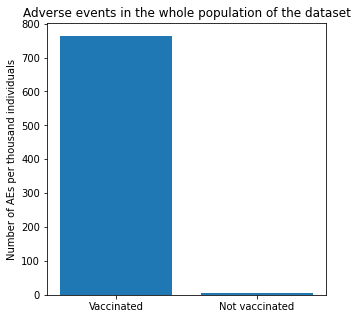

In [61]:
plt.figure(figsize = (5,5))
plt.bar(df_sum_all.index, df_sum_all['Number of events per thousand individuals'])
plt.ylabel('Number of AEs per thousand individuals')
plt.title('Adverse events in the whole population of the dataset')

# save figure in vector format, bbox_inches='tight' so that the plot is not cropped
plt.savefig('analysis/1a_total_AE_barplot.svg', bbox_inches='tight')

#### Incidence of AEs in all subjects
In further analysis: number of eids with AE is analysed (not total number of AEs occurring)

Make contingency table (not using pd.crosstab to avoid another huge dataset with all individuals and because we need to count unique IDs)

In [62]:
def contingency(df_event, id_vac, id_nvac, index = dict_vacORnot):
    """
    Makes a 2x2 contingency table, which can be used for the chi^2 test and calculating the risk ratio.
    
    Input:
    - df_event: a dataframe containing all events (AEs/deaths) considered in the analysis
    - id_vac: series containing ID's of each individual (with each individual listed once) within the given population.
    - id_nvac: same as id_vac but with all non-vaccinated individuals
    
    """

    # initialize contingency table
    crosstab = pd.DataFrame(columns = ['event', 'no event'], index = index)
    
    # fill contingency table with values in the subset

    for v in dict_vacORnot: # loop throug vaccinated vs. not

        
        # with events

        # number of nonvaccinated/vaccinated people with event = number of individuals with AEs
        crosstab.loc[v,'event'] = len(df_event[df_event['vaccinated']==dict_vacORnot[v]]['eid'].unique())
        
        # DELETE THIS FOR FINAL ANALYSIS
        # if we have no event (happens in the subset), add 1 for testing the plot and analysis further below
        # -> still visible in the output that it was added
        if crosstab.loc[v,'event']==0:
            crosstab.loc[v,'event']=1

            
        # without events

        if v == 'Vaccinated': # for vaccinated people

            # total number of vaccinated individuals - those with events
            crosstab.loc[v,'no event'] = len(id_vac) - crosstab.loc[v,'event']

        else: # for not vaccinated people
            
            # total number of unvaccinated individuals - those with events
            crosstab.loc[v,'no event'] = len(id_nvac) - crosstab.loc[v,'event']
            
    
    # adding margins to the contingency table (=total value as row and column)
    
    # vaccinated vs. not
    crosstab.loc['Total',:] = np.sum(crosstab, axis = 0)
    # event vs. no event
    crosstab.loc[:,'Total'] = np.sum(crosstab, axis = 1)

    return crosstab

In [63]:
crosstab_all = contingency(df_AEs, id_vac, id_nvac)

# save
crosstab_all.to_csv('analysis/1a_contigency_table.csv')

crosstab_all

,event,no event,Total
Vaccinated,149,812,961.0
Not vaccinated,9,10283,10292.0
Total,158,11095,11253.0


#### Chi-squared test

In [64]:
# define significance treshold
alpha = 0.05

# perform chi-squared test:
stat_1a, p_1a, dof_1a, expected_1a = sp.stats.chi2_contingency(crosstab_all.iloc[0:2,0:2], 1)

#save 
chi_square_1a = pd.DataFrame([[stat_1a, p_1a, dof_1a, expected_1a]],columns=['stat_1a', 'p_1a', 'dof_1a', 'expected_1a'])
chi_square_1a.to_csv('analysis/1a_chi_square.csv')

#### Risk ratio 
Done similar to Barda et al., but se and CI calculated as described on https://en.wikipedia.org/wiki/Relative_risk for simplicity. 

In [65]:
def riskratio(crosstab, z = 1.96):
    """
    Calculates the risk ratio.
    
    Returns the risk ratio with the confidence interval (CI) as a df and the adjusted contingency table:
    (RR, crosstab)
    
    Important: the input (crosstab) needs to have the following format:
    - 2x2
    - column 0 = events (e.g. AEs, deaths), column 1 = non-events
    - row 0 = intervention (e.g. vaccinated), column 1 = non-vaccinated
    """
    
    # calculating the risk ratio

    # risk of getting AE/ dying when vaccinated
    R_vac = crosstab.loc['Vaccinated','event']/crosstab.loc['Vaccinated','Total']
    # risk of getting "AE" or dying when not vaccinated
    R_nvac = crosstab.loc['Not vaccinated', 'event']/crosstab.loc['Not vaccinated', 'Total']

    # risk ratio
    RR = R_vac / R_nvac
    
    # natural log of the RR     
    logRR = np.log(RR) 

    # standard error
    se = np.sqrt(crosstab.loc['Vaccinated','no event']/ \
                 (crosstab.loc['Vaccinated','event']*crosstab.loc['Vaccinated','Total']) + \
                crosstab.loc['Not vaccinated','no event']/ \
                (crosstab.loc['Not vaccinated','event']*crosstab.loc['Not vaccinated','Total']))

    # Assuming normal distribution, 95% lie around 1.96 standard deviations of the mean.
    # as 95% CI is common, the z-score (z) 1.96 is put as the default value.

    # 1-alpha confidence interval (CI) 
    CI_lower = np.exp(np.log(RR) - se * z) # lower bound
    CI_upper = np.exp(np.log(RR) + se * z) # upper bound    
    
    # put the result in a series
    RR_result = pd.Series(data = [RR, CI_lower, CI_upper], index = ['RR', 'CI_lower', 'CI_upper'])
    
    return RR_result

In [66]:
RR_all = riskratio(crosstab_all)

# will later be saved after 1b 

### 1b) Same comparison in subset of subjects with underlying medical condition


#### Subset df to eids with AEs and underlying disease

In [67]:
# get dataset with only AEs AND people with underlying disease 
# = adverse events (events after vaccination) of people with underlying disease (= that had an event before vaccination)

# subset of the df with all AEs (df_AEs) with only people with underlying diseases (df_AEs_ud)
# reminder: leave R as adverse event (and general underlying disease) & Q as underlying disease.

# subset of clinical_vac df with only medical events before
df_ud= clinical_vac[clinical_vac['before_after_vaccine']== 'before']

# drop rows without icd10_code
df_ud.dropna(subset = ['icd10_code'], inplace = True)

# remove deaths to not consider people that died before
df_ud = df_ud[df_ud['icd10_code'] != 'death'] 

# ICD code R is kept in this analysis of general underlying diseases

# get id's of people with an underlying disease
id_ud = df_ud['eid'].unique()

# subset of the df with AEs with only people with an underlying disease
df_AEs_ud = df_AEs[df_AEs['eid'].isin(id_ud)]

C:\Users\moniz\AppData\Roaming\Python\Python38\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


In [68]:
# individuals in subset with only people with underlying disease AND the vaccine
id_ud_vac = df_ud[df_ud['vaccinated']==True]['eid'].unique()

# individuals in subset with only people with underlying disease AND NOT the vaccine
id_ud_nvac = df_ud[df_ud['vaccinated']==False]['eid'].unique()

#### Incidence of AE in subjects with underlying disease

In [69]:
df_sum_ud = incidence(df_AEs_ud, id_ud_vac, id_ud_nvac)

# save
df_sum_ud.to_csv('analysis/1b_total_AE_table.csv')

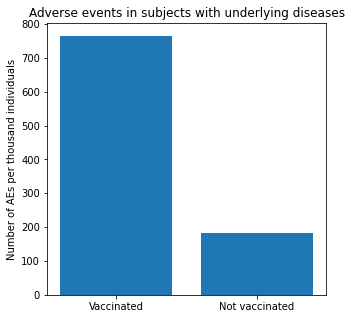

In [70]:
plt.figure(figsize = (5,5))
plt.bar(df_sum_ud.index, df_sum_ud['Number of events per thousand individuals'])
plt.ylabel('Number of AEs per thousand individuals')
plt.title('Adverse events in subjects with underlying diseases')

# save figure in vector format, bbox_inches='tight' so that the plot is not cropped
plt.savefig('analysis/1b_total_AE_barplot.svg', bbox_inches='tight')

#### Chi-squared test

In [71]:
# contingency table
crosstab_ud = contingency(df_AEs_ud, id_ud_vac, id_ud_nvac, index = dict_vacORnot)
crosstab_ud.to_csv('analysis/1b_contigency_table.csv')

In [72]:
# define significance treshold
alpha = 0.05

# perform chi-squared test:
stat_1b, p_1b, dof_1b, expected_1b = sp.stats.chi2_contingency(crosstab_ud.iloc[0:2,0:2], 1)

# save
chi_square_1b = pd.DataFrame([[stat_1b, p_1b, dof_1b, expected_1b]],columns=['stat_1b', 'p_1b', 'dof_1b', 'expected_1b'])
chi_square_1b.to_csv('analysis/1b_chi_square.csv')

#### Risk ratio

In [73]:
RR_ud = riskratio(crosstab_ud)
RR_ud


RR          4.794213
CI_lower    2.479386
CI_upper    9.270230
dtype: float64

In [74]:
# create a df for collecting the results of the risk ratio to compare the populations

# initialize
RR_result = pd.DataFrame(index = ['whole population', 'people with underlying diseases'], columns = ['RR', 'CI_lower', 'CI_upper'])

# fill it
# RR with data from all individuals in the mortality & clinical dataset
RR_result.loc['whole population',:] = RR_all
# RR with data from all individuals with underlying diseases
RR_result.loc['people with underlying diseases',:] = RR_ud

RR_result

# save 
pd.DataFrame(RR_result).to_csv('analysis/1a_b_RR_table.csv')

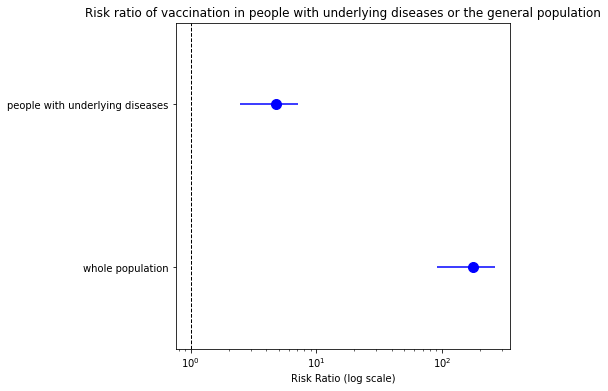

In [75]:
# plot the difference in RR with CI

# general figure configuration
plt.figure(figsize = (6,6))
plt.xscale("log")
plt.axvline(1, ls='--', linewidth=1, color='black')

# draw the RR
# RR results
x = RR_result['RR'].values
# error bar with same size in both directions
x_error = RR_result['RR']-RR_result['CI_lower']
# for equal spacing of the results
y = np.arange(len(RR_result))

# the plot
plt.errorbar(x, y, xerr = x_error, marker = "o", markersize = 10, color = 'b', ls='none')

# labelling
plt.xlabel('Risk Ratio (log scale)')
plt.title('Risk ratio of vaccination in people with underlying diseases or the general population') # renee: Risk ratio of vaccination on an adverse event in subjects with underlying diseases and the entire population
# labelling with ICD10 categories
plt.yticks(ticks = y, labels = RR_result.index) 
plt.ylim(-0.5,1.5)

# save figure in vector format, bbox_inches='tight' so that the plot is not cropped
plt.savefig('analysis/1a_b_RR_plot.svg', bbox_inches='tight')

### 1c) Same comparison in subset of subjects with specific underlying medical condition 

#### Loop through the ICD-10 categories

ICD10 codes are structured. The following website was used for looking up the meanings of the categories (e.g. respiratory diseases):
https://www.icd10data.com/ICD10CM/Codes

In [76]:
# dictionary of disease categories to analyse, from https://www.icd10data.com/ICD10CM/Codes
dict_cat = {('A','B'):'Certain infectious and parasitic diseases',
           ('C','D0','D1','D2','D3','D4'):'Neoplasms',
           ('D5','D6','D7','D8'):'Diseases of the blood and blood-forming organs and certain disorders involving the immune mechanism',
           'E':'Endocrine, nutritional and metabolic diseases',
           'F':'Mental, Behavioral and Neurodevelopmental disorders',
           'G':'Diseases of the nervous system',
           ('H0','H1','H2','H3','H4','H5'):'Diseases of the eye and adnexa',
           ('H6','H7','H8', 'H9'): 'Diseases of the ear and mastoid process',
           'I':'Diseases of the circulatory system',
           'J':'Diseases of the respiratory system',
           'K':'Diseases of the digestive system',
           'L':'Diseases of the skin and subcutaneous tissue',
           'M':'Diseases of the musculoskeletal system and connective tissue',
           'N':'Diseases of the genitourinary system',
           'Q':'Congenital malformations, deformations and chromosomal abnormalities'}

# As mentioned by Barda et al., adjustment for multiple comparisons is not commonly done in studies regarding safety.
alpha = 0.05

# initialize 
# dataframe for collecting number of AEs per thousands with/without vaccinated people for all categories
df_sum_cat_all = pd.DataFrame(columns = dict_vacORnot, index=dict_cat.values()) 

# df for saving categories & their p-values
#df_chi2_cat = pd.DataFrame(columns = ['p-value', 'significant'], index=dict_cat.values())

# df for saving the risk ratio and CIs for the plot
RR_result_cat = pd.DataFrame(index = dict_cat.values(), columns = ['RR', 'CI_lower', 'CI_upper'])

# df for saving categories and their p-value, significance, RR and CI
df_combined = pd.DataFrame(columns = ['P-value', 'Significant', 'Risk Ratio', 'Confidence Interval'], index = dict_cat.values())



for i, ic in enumerate(dict_cat): # loop over ICD10 codes of each disease category
    
    # get dataset with only AEs AND people with specific underlying disease
    # subset of the df with all AEs (df_AEs) with only people with specific underlying diseases
    # reminder: leave R as adverse event & Q as underlying disease.
    # df_ud = subset of clinical_vac df with only diagnoses before vaccine as defined further above

    # subset with only underlying diseases within the specific category
    df_cat = df_ud[df_ud['icd10_code'].str.startswith(ic)]

    # IDs with underlying disease in the specific category
    id_cat = df_cat['eid'].unique()

    # subset of the df with AEs with only people with underlying disease in the specific category
    df_AEs_cat = df_AEs[df_AEs['eid'].isin(id_cat)]

    # get IDs of individuals in this subset with vs without vaccine 
    id_cat_vac = df_cat[df_cat['vaccinated']==True]['eid'].unique() # with vaccine
    id_cat_nvac = df_cat[df_cat['vaccinated']==False]['eid'].unique() # without vaccine

    ################################################################################
    # calculate the number of AEs per thousand people and save the result in a table
    df_sum_cat = incidence(df_AEs_cat, id_cat_vac, id_cat_nvac)
    
    # put in the values from the summary incidence table
    df_sum_cat_all.loc[dict_cat[ic],:] = df_sum_cat.loc[:, 'Number of events per thousand individuals']
    
    
    ################################################################################    
    # contingency table
    crosstab_cat = contingency(df_AEs_cat, id_cat_vac, id_cat_nvac, index = dict_vacORnot)
    
    ###############################################################################
    # perform chi-squared test:
    stat, p, dof, expected = sp.stats.chi2_contingency(crosstab_cat.iloc[0:2,0:2], 1)     ## changed crosstab_ud to crosstab_cat

    # save the p-value in the df
    df_combined.loc[dict_cat[ic],'P-value'] = p
    
    # mark in which categories there is a significant difference between vaccinated and not vaccinated
    if p <= alpha/2: # divided by two because of two-sided test (number of AEs could be higher or lower in vaccinated)
        df_combined.loc[dict_cat[ic],'Significant'] = 'Yes'
    else:
        df_combined.loc[dict_cat[ic],'Significant'] = 'No'
       
    
    ###############################################################################
    # risk ratio
    RR_cat = riskratio(crosstab_cat)

    # fill the df with the RR results for the plot
    RR_result_cat.loc[dict_cat[ic],:] = RR_cat
    
    CI_rounded = (round(RR_cat[1], 2), round(RR_cat[2], 2)) # round to one more decimal place than the original data has
    
    # new fill df with RR
    df_combined.loc[dict_cat[ic], ['Risk Ratio', 'Confidence Interval']] = round(RR_cat[0],2) , CI_rounded
    
    


C:\Users\moniz\AppData\Roaming\Python\Python38\site-packages\pandas\core\internals\blocks.py:938: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr_value = np.asarray(value)


#### Total number of AEs in IC-10 categories

In [77]:
# total number of AEs in different categories
df_sum_cat_all.sort_values(by = 'Vaccinated', ascending = False, inplace = True) # sorting

# save
df_sum_cat_all.to_csv('analysis/1c_total_AE_table.csv')

#### Outcomes of Chi squared test and RR

In [78]:
# df with p-value, significance, RR and CI
df_combined.to_csv('analysis/1c_chi_square_RR_table.csv')

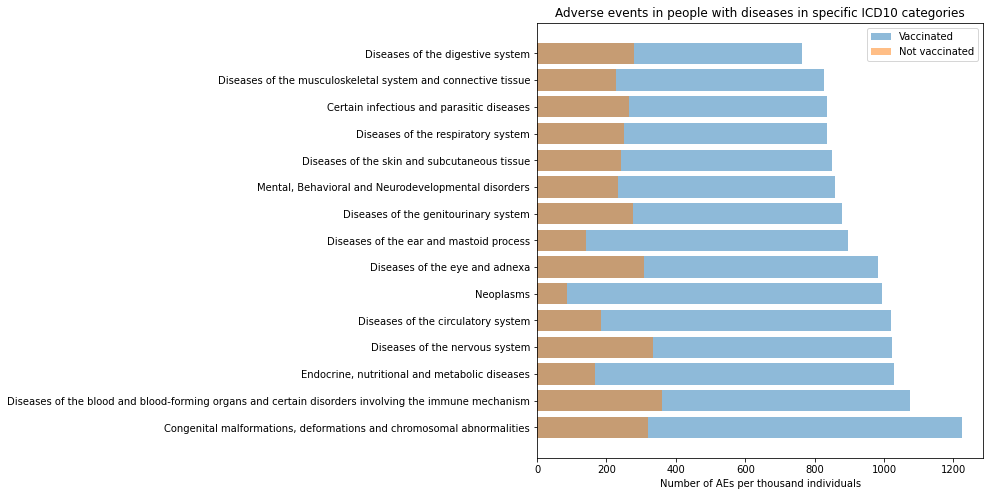

In [79]:
plt.figure(figsize = (8,8))

# plot results for vaccinated and not on top of each other
for v in dict_vacORnot:
    plt.barh(df_sum_cat_all.index, df_sum_cat_all[v], alpha = 0.5, label = v)

# labelling
plt.title('Adverse events in people with diseases in specific ICD10 categories')
plt.xlabel('Number of AEs per thousand individuals')
plt.legend(loc = "upper right")

# save figure in vector format, bbox_inches='tight' so that the plot is not cropped
plt.savefig('analysis/1c_AE_barplot.svg', bbox_inches='tight')

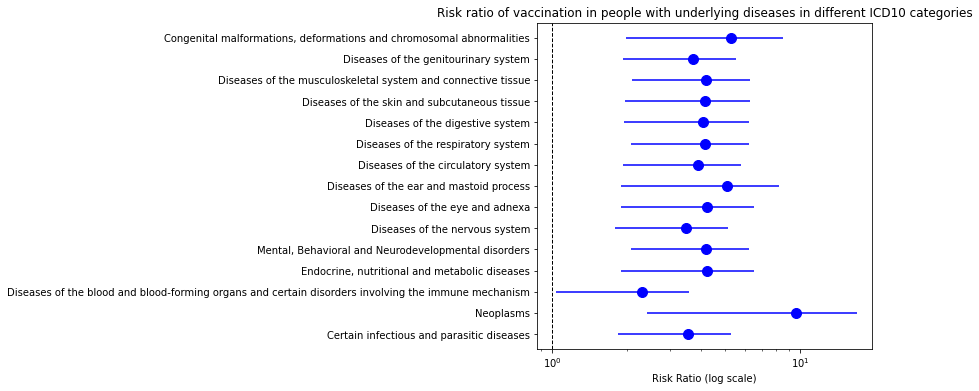

In [80]:
# plot the RR with CI

# general figure configuration
plt.figure(figsize = (6,6))
plt.xscale("log")
plt.axvline(1, ls='--', linewidth=1, color='black')

# draw the RR
# RR results
x = RR_result_cat['RR'].values
# error bar with same size in both directions
x_error = RR_result_cat['RR']-RR_result_cat['CI_lower']
# for equal spacing of the results
y = np.arange(len(RR_result_cat))

# the plot
plt.errorbar(x, y, xerr = x_error, marker = "o", markersize = 10, color = 'b', ls='none')

# labelling
plt.xlabel('Risk Ratio (log scale)')
plt.title('Risk ratio of vaccination in people with underlying diseases in different ICD10 categories')
# labelling with ICD10 categories
plt.yticks(ticks = y, labels = RR_result_cat.index) 

# save figure in vector format, bbox_inches='tight' so that the plot is not cropped
plt.savefig('analysis/1c_AE_RR.svg', bbox_inches='tight')

## 2) Effect of the vaccination on mortality

a) Comparison of mortality rate after vaccination of vaccinated and unvaccinated people

b) Same comparison in subset of subjects with underlying medical condition

c) Same comparison in subset of subjects with specific underlying medical condition 


### 2a) Comparison of mortality rate after vaccination of vaccinated and unvaccinated people

#### Subset clinical df to only death entries

In [81]:
# subset of clinical_vac dataset for adverse events (=after vaccine)
df_deaths = clinical_vac[clinical_vac['before_after_vaccine']== 'after']

# make dataframe with only deaths 
df_deaths = df_deaths[df_deaths['icd10_code'] == 'death'] 

#### Mortality in entire study population

Make contingency table (not using pd.crosstab to avoid another huge dataset with all individuals and because we need to count unique IDs)

In [82]:
crosstab_all_deaths = contingency(df_deaths, id_vac, id_nvac)

# save
crosstab_all_deaths.to_csv('analysis/2a_contigency_table.csv')

#### Chi-squared test

In [83]:
# perform chi-squared test and name variavles differently for each test
# e.g. 1a, 1b, etc.
stat_2a, p_2a, dof_2a, expected_2a = sp.stats.chi2_contingency(crosstab_all_deaths.iloc[0:2,0:2], 1)

# save
chi_square_2a = pd.DataFrame([[stat_2a, p_2a, dof_2a, expected_2a]],columns=['stat_2a', 'p_2a', 'dof_2a', 'expected_2a'])
chi_square_2a.to_csv('analysis/2a_chi_square.csv')

#### Risk ratio

In [84]:
RR_all_deaths = riskratio(crosstab_all_deaths)

# save together with 2b

### 2b) Same comparison in subset of subjects with underlying medical condition

In [85]:
# subset of the df with deaths with only people with an underlying disease - non in this dataset
df_deaths_ud = df_deaths[df_deaths['eid'].isin(id_ud)]

#delete
df_deaths_ud


,Unnamed: 0_x,eid,event_dt,code,icd10_code,Unnamed: 0_y,issue_dt,vaccinated,days_after_vaccine,before_after_vaccine


In [86]:
# should we keep this output?

# also here is total number of deaths not needed, as it is the same as later seen in the crosstable.
df_sum_ud = incidence(df_deaths_ud, id_ud_vac, id_ud_nvac)
df_sum_ud

,Number of events,Number of individuals,Number of events per thousand individuals
Vaccinated,0.5,960,0.520833
Not vaccinated,0.5,278,1.798561


Text(0.5, 1.0, 'Deaths in people with underlying diseases')

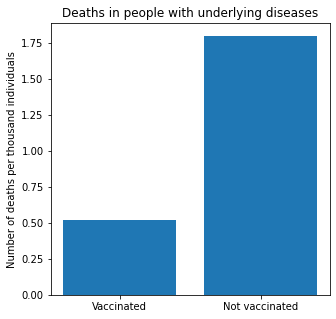

In [87]:
# delete?
plt.figure(figsize = (5,5))
plt.bar(df_sum_ud.index, df_sum_ud['Number of events per thousand individuals'])
plt.ylabel('Number of deaths per thousand individuals')
plt.title('Deaths in people with underlying diseases')

Chi-squared test

In [88]:
# contingency table
crosstab_ud_deaths = contingency(df_deaths_ud, id_ud_vac, id_ud_nvac, index = dict_vacORnot)

# save
crosstab_ud_deaths.to_csv('analysis/2b_contigency_table.csv')

In [89]:
# perform chi-squared test:
stat_2b, p_2b, dof_2b, expected_2b = sp.stats.chi2_contingency(crosstab_ud_deaths.iloc[0:2,0:2], 1)

# save
chi_square_2b = pd.DataFrame([[stat_2a, p_2a, dof_2a, expected_2a]],columns=['stat_2a', 'p_2a', 'dof_2a', 'expected_2a'])
chi_square_2b.to_csv('analysis/2b_chi_square.csv')


Calculate and plot risk ratio

In [90]:
RR_ud_deaths = riskratio(crosstab_ud_deaths)

# delete
RR_ud_deaths

RR          0.289583
CI_lower    0.018171
CI_upper    4.615084
dtype: float64

In [91]:
# create a df for collecting the results of the risk ratio to compare the populations

# initialize
RR_result_deaths = pd.DataFrame(index = ['Whole population', 'People with underlying diseases'], columns = ['RR', 'CI_lower', 'CI_upper'])

# fill it
# RR with data from all individuals in the mortality & clinical dataset
RR_result_deaths.loc['Whole population',:] = RR_all_deaths
# RR with data from all individuals with underlying diseases
RR_result_deaths.loc['People with underlying diseases',:] = RR_ud_deaths

# save
pd.DataFrame(RR_result_deaths).to_csv('analysis/1a_b_RR.csv')

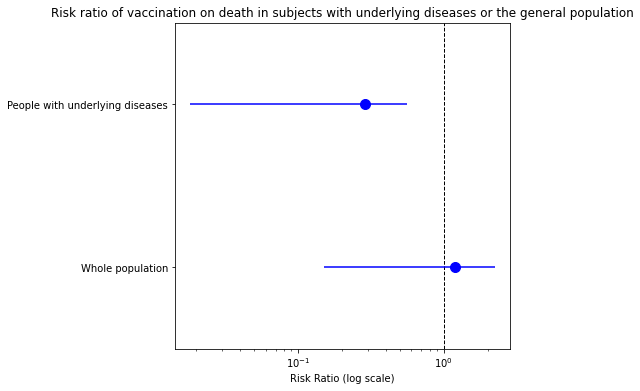

In [92]:
# plot the difference in RR with CI

# general figure configuration
plt.figure(figsize = (6,6))
plt.xscale("log")
plt.axvline(1, ls='--', linewidth=1, color='black')

# draw the RR
# RR results
x = RR_result_deaths['RR'].values
# error bar with same size in both directions
x_error = RR_result_deaths['RR']-RR_result_deaths['CI_lower']
# for equal spacing of the results
y = np.arange(len(RR_result_deaths))

# the plot
plt.errorbar(x, y, xerr = x_error, marker = "o", markersize = 10, color = 'b', ls='none')

# labelling
plt.xlabel('Risk Ratio (log scale)')
plt.title('Risk ratio of vaccination on death in subjects with underlying diseases or the general population') 
# labelling with ICD10 categories
plt.yticks(ticks = y, labels = RR_result_deaths.index) 
plt.ylim(-0.5,1.5)

# save figure in vector format, bbox_inches='tight' so that the plot is not cropped
plt.savefig('analysis/2a_b_RR_plot.svg', bbox_inches='tight')

### 2c) Same comparison in subset of subjects with specific underlying medical condition 

In [93]:
# initialize 

# dataframe for collecting number of AEs per thousands with/without vaccinated people for all categories
df_sum_cat_all_deaths = pd.DataFrame(columns = dict_vacORnot, index=dict_cat.values()) 

# df for saving the risk ratio and CI
RR_result_cat_deaths = pd.DataFrame(index = dict_cat.values(), columns = ['RR', 'CI_lower', 'CI_upper'])

# df for saving categories and their p-value, significance, RR and CI
df_combined_deaths = pd.DataFrame(columns = ['P-value', 'Significant', 'Risk Ratio', 'Confidence Interval'], index = dict_cat.values())


for i, ic in enumerate(dict_cat): # loop over ICD10 codes of each disease category
    
    # get dataset with only deaths AND people with specific underlying disease
    # subset of the df with all deaths (df_deaths) with only people with specific underlying diseases
    # reminder: leave R as adverse event & Q as underlying disease.
    # df_ud = subset of clinical_vac df with only diagnoses before vaccine as defined further above

    # subset with only underlying diseases within the specific category (=ic)
    df_cat = df_ud[df_ud['icd10_code'].str.startswith(ic)]

    # IDs with underlying disease in the specific category
    id_cat = df_cat['eid'].unique()

    # subset of the df with deaths after vaccination only in people with underlying disease in the specific category
    df_deaths_cat = df_deaths[df_deaths['eid'].isin(id_cat)]

    # get IDs of individuals in this subset with vs without vaccine 
    id_cat_vac = df_cat[df_cat['vaccinated']==True]['eid'].unique() # with vaccine
    id_cat_nvac = df_cat[df_cat['vaccinated']==False]['eid'].unique() # without vaccine

    ################################################################################
    # calculate the number of deaths per thousand people and save the result in a table
    df_sum_cat_deaths = incidence(df_deaths_cat, id_cat_vac, id_cat_nvac)
    
    # put in the values from the summary table
    df_sum_cat_all_deaths.loc[dict_cat[ic],:] = df_sum_cat_deaths.loc[:,'Number of events per thousand individuals']
    
    
    ################################################################################    
    # contingency table
    crosstab_cat = contingency(df_deaths_cat, id_cat_vac, id_cat_nvac, index = dict_vacORnot)
    
    ###############################################################################
    # perform chi-squared test:
    stat, p, dof, expected = sp.stats.chi2_contingency(crosstab_cat.iloc[0:2,0:2], 1)       # changed to crosstab_cat from crosstab_ud
    
    # save the p-value in the df
    df_combined_deaths.loc[dict_cat[ic],'P-value'] = p
    
    # mark in which categories there is a significant difference between vaccinated and not vaccinated
    if p <= alpha/2: # divided by two because of two-sided test (number of AEs could be higher or lower in vaccinated)
        df_combined_deaths.loc[dict_cat[ic],'Significant'] = 'Yes'
    else:
        df_combined_deaths.loc[dict_cat[ic],'Significant'] = 'No'
       
    ###############################################################################
    # risk ratio
    RR_cat = riskratio(crosstab_cat)

    # fill the df with the RR results for the plot later
    RR_result_cat_deaths.loc[dict_cat[ic],:] = RR_cat
    
    CI_rounded = (round(RR_cat[1], 2), round(RR_cat[2], 2)) # round to one more decimal place than the original data has
    
    # fill df with RR
    df_combined_deaths.loc[dict_cat[ic], ['Risk Ratio', 'Confidence Interval']] = round(RR_cat[0],2) , CI_rounded
    

df_sum_cat_all_deaths.sort_values(by = 'Vaccinated', ascending = False, inplace = True) # sorting

# save
df_sum_cat_all_deaths.to_csv('analysis/2c_total_mortality_table.csv')

C:\Users\moniz\AppData\Roaming\Python\Python38\site-packages\pandas\core\internals\blocks.py:938: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr_value = np.asarray(value)


In [94]:
# df with p-value, significance, RR and CI
df_combined_deaths.to_csv('analysis/2c_chi_square_RR_table.csv')

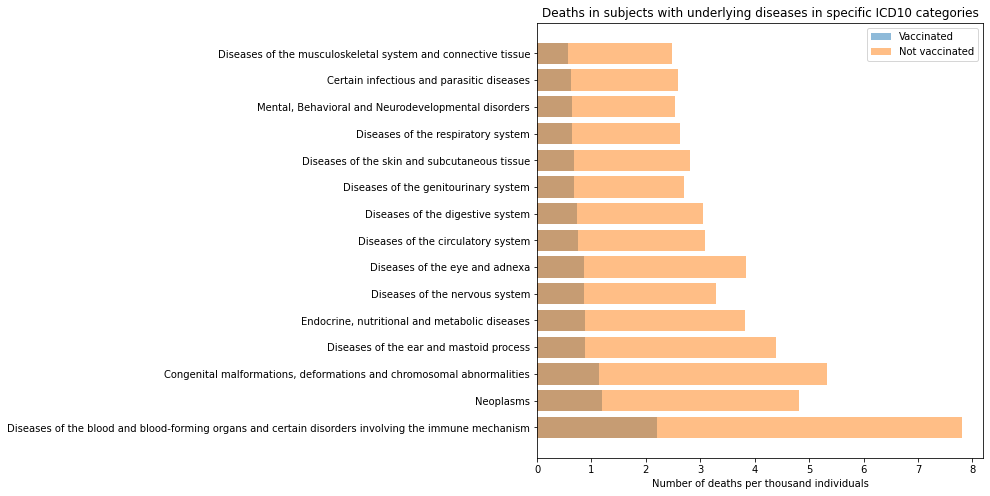

In [95]:
plt.figure(figsize = (8,8))

# plot results for vaccinated and not on top of each other
for v in dict_vacORnot:
    plt.barh(df_sum_cat_all_deaths.index, df_sum_cat_all_deaths[v], alpha = 0.5, label = v)

# labelling
plt.title('Deaths in subjects with underlying diseases in specific ICD10 categories')
plt.xlabel('Number of deaths per thousand individuals')
plt.legend(loc = "upper right")

# save figure in vector format, bbox_inches='tight' so that the plot is not cropped
plt.savefig('analysis/2c_deaths_barplot.svg', bbox_inches='tight')

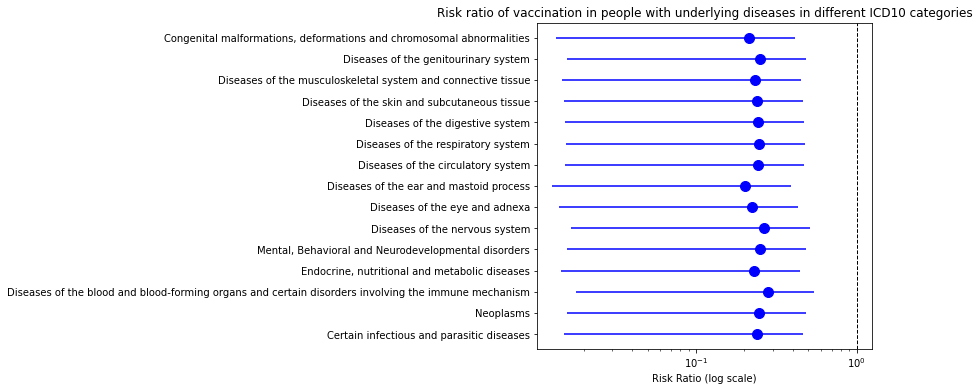

In [96]:
# plot the RR with CI

# general figure configuration
plt.figure(figsize = (6,6))
plt.xscale("log")
plt.axvline(1, ls='--', linewidth=1, color='black')

# draw the RR
# RR results
x = RR_result_cat_deaths['RR'].values
# error bar with same size in both directions
x_error = RR_result_cat_deaths['RR']-RR_result_cat_deaths['CI_lower']
# for equal spacing of the results
y = np.arange(len(RR_result_cat_deaths))

# the plot
plt.errorbar(x, y, xerr = x_error, marker = "o", markersize = 10, color = 'b', ls='none')

# labelling
plt.xlabel('Risk Ratio (log scale)')
plt.title('Risk ratio of vaccination in people with underlying diseases in different ICD10 categories') # renee: Risk ratio of vaccination on an adverse event in subjects with underlying diseases in specific ICD-10 categories
# labelling with ICD10 categories
plt.yticks(ticks = y, labels = RR_result_cat_deaths.index) 

# save figure in vector format, bbox_inches='tight' so that the plot is not cropped
plt.savefig('analysis/2c_deaths_RR.svg', bbox_inches='tight')

# 3. Results

# 4. Discussion

# References
Choi, W. S. & Cheong, H. J. COVID-19 Vaccination for People with Comorbidities. Infect Chemother 53, 155-158, doi:10.3947/ic.2021.0302 (2021).